<a href="https://colab.research.google.com/github/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec9-GAN.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code

---
# Lecture notes - Generative Adversarial Networks (GAN)
---

This is the lecture note for **GAN**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to GANs. I encourage you to read further about GANs. </p>

Read more:

- [GAN - wikipedia](https://en.wikipedia.org/wiki/Generative_adversarial_network)
- [Zero-sum game](https://en.wikipedia.org/wiki/Zero-sum_game)
- [Generative adversarial nets - Goodfellow et. al. (2014)](https://arxiv.org/pdf/1406.2661.pdf)
- [DCGAN - Radford A., Metz L. (2016)](https://arxiv.org/pdf/1511.06434.pdf)
- [DCGAN - TensorFlow](https://www.tensorflow.org/tutorials/generative/dcgan)

Code is strongly inspired from here
- [Geron (2019) pp. 592 - 600](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

---

## GAN

A GAN network consists of a generator and a discriminator
- Generator - goal is to generate samples with same probability distributions as the training samples in order to trick the discriminator in believing these generated samples are real
- Discriminator - goal is to classify a sample as either real or fake. 

In summary we have two neural networks competing against each other, where one is the adversary of the other. This results in a zero-sum game where the generators purpose is to maximise the discriminators loss and the discriminator aims to minimize its loss. 

4431872/4422102 [==============================] - 0s 0us/step


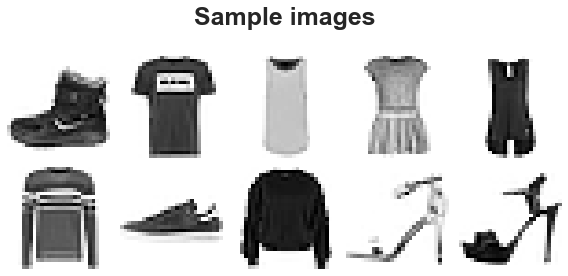

In [1]:
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-white")

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

def display_images(data, title = "Sample images"):
    fig, axes = plt.subplots(2, 5, figsize=(8, 4))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i])
        ax.axis("off")

    fig.suptitle(title, fontsize=25, fontweight="bold")
    fig.set_tight_layout("tight")

display_images(X_train)

---
## Prepare data

- create batches

In [2]:
import tensorflow as tf 

batch_size = 32
X_train = X_train.astype("float32")/255
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

<class 'numpy.ndarray'>


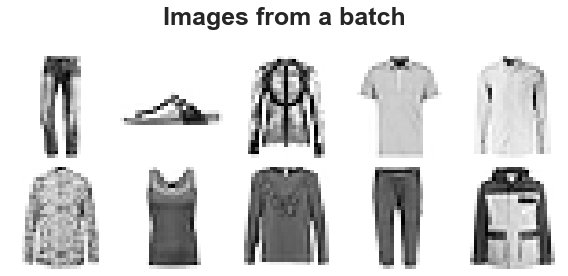

In [3]:
# takes 1 batch from the dataset which is an iterator 
for data in dataset.take(1):
    print(type(data.numpy()))
    display_images(data.numpy(), "Images from a batch")

---
## Build model

- generator - an MLP that takes Gaussian noise as input and outputs an image 
  
- discriminator - an MLP that performs binary classification

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.initializers import LecunNormal

coding_size = 30
image_shape = X_train[0].shape # (28x28)


generator = Sequential(
    [   # selu is scaled exponential linear unit
        Dense(100, activation="selu", kernel_initializer=LecunNormal()),
        Dense(150, activation="selu", kernel_initializer=LecunNormal()),
        Dense(image_shape[0] * image_shape[1], activation="sigmoid"),
        Reshape(image_shape),
    ]
)

discriminator = Sequential([
    Flatten(input_shape = image_shape),
    Dense(100, activation="selu", kernel_initializer=LecunNormal()),
    Dense(150, activation="selu", kernel_initializer=LecunNormal()),
    Dense(1, activation = "sigmoid")
])

gan = Sequential([generator, discriminator])


# we need to separately train discriminator and generator 
discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

# trainable attribute taken into account only when compiling the model
# --> discriminator trainable when running discriminator.fit() or discriminator.train_on_batch()
# discriminators weights are frozen in gan model and is not trainable there
discriminator.trainable = False
gan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")


---
## Train model

epoch=0
epoch=1
epoch=2


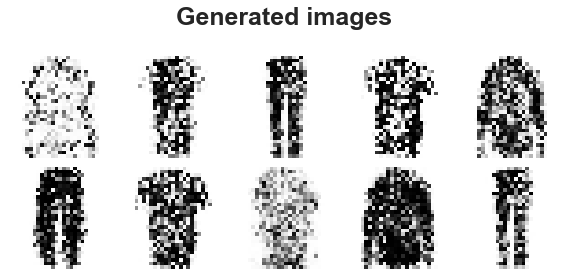

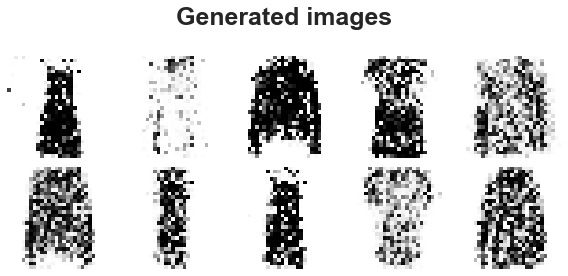

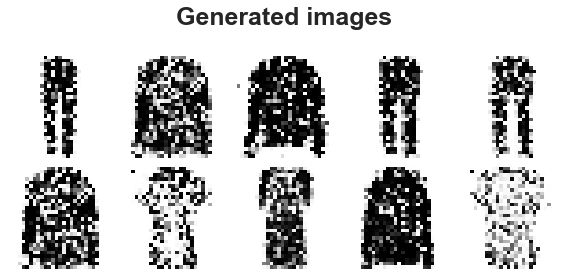

In [5]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"{epoch=}")
        for X_batch in dataset:
            # phase 1 - discriminator
            noise = tf.random.normal([batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_real = tf.concat([generated_images, X_batch], axis=0)
            y_train1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_real, y_train1)

            # phase 2 - generator
            noise = tf.random.normal([batch_size, coding_size])
            y_train2 = tf.constant([[1.0]] * batch_size)

            # freeze the discriminator as we only want gradient signal from discriminator to generator
            discriminator.trainable = False
            gan.train_on_batch(noise, y_train2)

        display_images(generator(noise).numpy(), "Generated images")

train_gan(gan, dataset, batch_size, coding_size, 3)

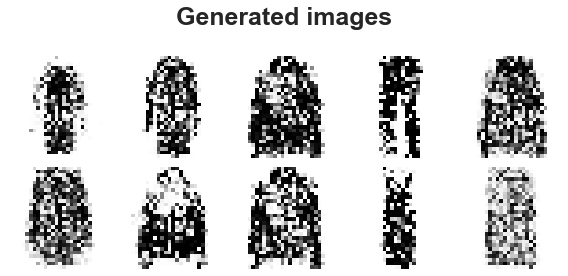

In [6]:
noise = tf.random.normal(shape = [10, coding_size])
display_images(generator(noise).numpy(), "Generated images")

---
## Deep convolutional GAN (DCGAN)

As we are generating images, it is better to use convolutional layers as they are better at working with images 

In [7]:
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2DTranspose,
    Conv2D,
    LeakyReLU,
    Dropout,
)


coding_size = 100

conv_settings = dict(
    kernel_size=5,
    strides=2,
    padding="same",
)

generator = Sequential(
    [
        Dense(7 * 7 * 128, input_shape=[coding_size]),
        Reshape([7, 7, 128]),
        BatchNormalization(),
        Conv2DTranspose(
            64, activation="selu", kernel_initializer=LecunNormal, **conv_settings
        ),
        BatchNormalization(),
        Conv2DTranspose(1, activation="tanh", **conv_settings),
    ]
)

discriminator = Sequential(
    [
        Conv2D(
            64,
            input_shape=(28, 28, 1),
            activation=LeakyReLU(alpha=0.2),
            **conv_settings
        ),
        Dropout(0.4),
        Conv2D(128, activation=LeakyReLU(alpha=0.2), **conv_settings),
        Dropout(0.4),
        Flatten(),
        Dense(1, activation="sigmoid")
    ]
)

dcgan = Sequential([generator, discriminator])

discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
discriminator.trainable = False
dcgan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")


In [8]:
# scales the data to -1 to 1 as tanh outputs -1 to 1 
scaled_X_train = X_train.reshape(-1, 28, 28, 1) * 2 - 1
print(scaled_X_train.min(), scaled_X_train.max())

dataset = tf.data.Dataset.from_tensor_slices(scaled_X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

-1.0 1.0


epoch=0
epoch=1


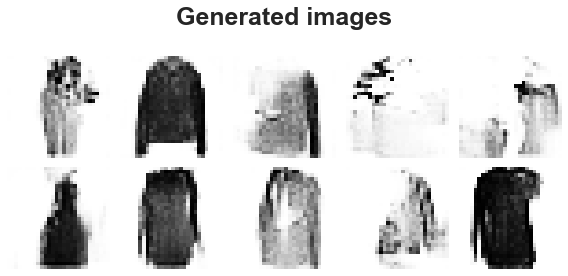

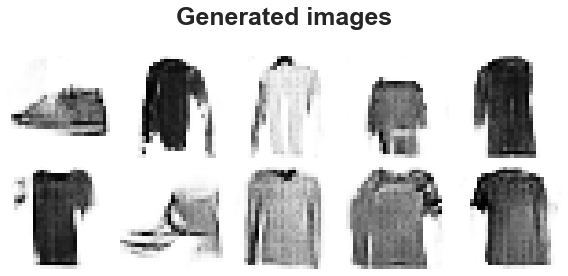

In [9]:
train_gan(dcgan, dataset, batch_size, coding_size, 2)

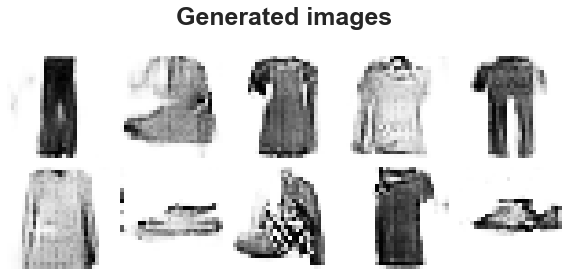

In [10]:
noise = tf.random.normal(shape = [10, coding_size])
display_images(generator(noise).numpy(), "Generated images")